In [1]:
from Pneumotracker_func import get_and_create_dirs, build_df, build_train_model, model_smpl, model_cmpl, segment_image, dice_coef_loss, dice_coef
# from Segmentation_func import 

import os
import pandas as pd
from keras.models import load_model
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

orig_path, seg_path = r'D:\MOOCS\DataScientest\Projet\Dataset\chest_xray\chest_xray', r'D:\MOOCS\DataScientest\Projet\UNET\segmentation'
orig_file_ext = 'jpeg'
smpl_checkp_name = r'.\Models\model_simple_orig_224_rgb.h5'
smpl_hist_name = r'.\Models\history_simple_orig_224_rgb.csv'
seg_model = r'.\Models\unet_lung_seg.hdf5'
cmpl_orig_checkp_name = r'.\Models\model_complex_orig_224_rgb.h5'
cmpl_orig_hist_name = r'.\Models\history_complex_orig_224_rgb.csv'
cmpl_seg_checkp_name = r'.\Models\model_complex_seg_224_rgb.h5'
cmpl_seg_hist_name = r'.\Models\history_complex_seg_224_rgb.csv'

## I. Intialize variables

In [2]:
orig_path, seg_path, orig_file_ext, seg_model = get_and_create_dirs()

Checks for paths for original and segmented images.
Original and segmented images folders must be organized in the exact same structure (images in the same folders and sub-folders).

Input root path for original images (default github folder):


Input root path for segmented images if exists or needs to be created (default github folder):


What is the file extension for original images (default jpeg) ?


What is the path to the segmentation model checkpoint (default github folder) ?



## II. Build dataset DataFrame

In [3]:
print('Building dataset DataFrame')

df = build_df(path_orig = orig_path,
              orig_img_ext = 'jpeg',
              path_seg = seg_path,
              seg_img_ext = 'png')

100%|██████████| 9/9 [00:00<?, ?it/s]

Building dataset DataFrame
Done


#### Necessary to ensure same data split between file systems

In [4]:
df = pd.read_csv('df_all.csv', index_col = 0)
df['Filepath_orig'] = df['Filepath_orig'].apply(lambda x: x.replace('../input/chest-xray-pneumonia/chest_xray/chest_xray', orig_path).replace("/", "\\"))
df['Filepath_seg'] = df['Filepath_seg'].apply(lambda x: x.replace('../input/segmentation-finale/segmentation', seg_path).replace("/", "\\"))
df.head()

,Label_name,Label_int,Label_pathology,Label_pathology_int,Filename_orig,Filepath_orig,Filename_seg,Filepath_seg
0,PNEUMONIA,1,bacteria,1,person1947_bacteria_4876.jpeg,.\chest_xray\val\PNEUMONIA\person1947_bacteria...,person1947_bacteria_4876.png,.\segmentation\val\PNEUMONIA\person1947_bacter...
1,PNEUMONIA,1,bacteria,1,person1946_bacteria_4875.jpeg,.\chest_xray\val\PNEUMONIA\person1946_bacteria...,person1946_bacteria_4875.png,.\segmentation\val\PNEUMONIA\person1946_bacter...
2,PNEUMONIA,1,bacteria,1,person1952_bacteria_4883.jpeg,.\chest_xray\val\PNEUMONIA\person1952_bacteria...,person1952_bacteria_4883.png,.\segmentation\val\PNEUMONIA\person1952_bacter...
3,PNEUMONIA,1,bacteria,1,person1954_bacteria_4886.jpeg,.\chest_xray\val\PNEUMONIA\person1954_bacteria...,person1954_bacteria_4886.png,.\segmentation\val\PNEUMONIA\person1954_bacter...
4,PNEUMONIA,1,bacteria,1,person1951_bacteria_4882.jpeg,.\chest_xray\val\PNEUMONIA\person1951_bacteria...,person1951_bacteria_4882.png,.\segmentation\val\PNEUMONIA\person1951_bacter...


## III. Building and training simple CNN

In [5]:
smpl_checkp_name = input('Input path for simple model checkpoint (XXXX.h5) (default github checkpoint path).\n') or r'.\Models\model_simple_orig_224_rgb.h5'
smpl_hist_name = input('Input path for simple model history (XXXX.csv) (default github history path).\n') or r'.\Models\history_simple_orig_224_rgb.csv'

train = False

if 'smpl_checkp_name' in locals():
    if os.path.exists(smpl_checkp_name):
        train = True if (input('Simple model checkpoint found. Do you want to retrain model (Y/N, default N)?') or 'N') == 'Y' else False
    else:
        train = True
else:
    train = True    

X = df['Filepath_orig']
Y = df['Label_name']

md_smpl_eval, history_smpl, smpl_model_class_rep, smpl_model_conf_mat, smpl_model = build_train_model(X, Y, model_smpl, 2, 32, 30, smpl_checkp_name, smpl_hist_name, train)

Input path for simple model checkpoint (XXXX.h5) (default github checkpoint path).

Input path for simple model history (XXXX.csv) (default github history path).

Simple model checkpoint found. Do you want to retrain model (Y/N, default N)?

Splitting data

Building Data Generators
Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.

Evaluating model
28/28 [==============================] - 15s 547ms/step - loss: 0.1406 - accuracy: 0.9522
Loss:  0.14058370888233185
Accuracy:  95.22184133529663 %


#### III.1.Training history

''

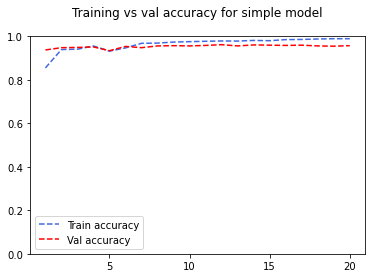

In [6]:
plt.plot(history_smpl.index + 1, history_smpl['accuracy'], color = 'royalblue', linestyle = '--', label = 'Train accuracy')
plt.plot(history_smpl.index + 1, history_smpl['val_accuracy'], color = 'red', linestyle = '--', label = 'Val accuracy')
plt.ylim([0, 1.0])
plt.xticks([5, 10, 15, 20])
plt.legend(loc = 'best')
plt.title('Training vs val accuracy for simple model', pad = 20)
;

#### III.2. Classification report

In [7]:
smpl_model_class_rep

,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.918803,0.964341,0.952218,0.941572,0.952011
recall,0.903361,0.970359,0.952218,0.936860,0.952218
f1-score,0.911017,0.967341,0.952218,0.939179,0.952090
support,238.000000,641.000000,0.952218,879.000000,879.000000


#### III.3. Confusion matrix

In [8]:
smpl_model_conf_mat

Predicted,NORMAL,PNEUMONIA
Real,,
NORMAL,215,23
PNEUMONIA,19,622


## IV. Building and training complex CNN with original images

In [9]:
cmpl_orig_checkp_name = input('Input path for complex model with original images checkpoint (XXXX.h5) (default github checkpoint path).\n') or r'.\Models\model_complex_orig_224_rgb.h5'
cmpl_orig_hist_name = input('Input path for complex model with original images history (XXXX.csv) (default github history path).\n') or r'.\Models\history_complex_orig_224_rgb.csv'

train = False

if 'cmpl_orig_checkp_name' in locals():
    if os.path.exists(cmpl_orig_checkp_name):
        train = True if (input('Complex model with original images checkpoint found. Do you want to retrain model (Y/N, default N)?') or 'N') == 'Y' else False
    else:
        train = True
else:
    train = True    

X = df['Filepath_orig']
Y = df['Label_name']

md_cmpl_orig_eval, history_cmpl_orig, cmpl_orig_model_class_rep, cmpl_orig_model_conf_mat, cmpl_orig_model = build_train_model(X, Y, model_cmpl, 2, 32, 30, cmpl_orig_checkp_name, cmpl_orig_hist_name, train)

Input path for complex model with original images checkpoint (XXXX.h5) (default github checkpoint path).

Input path for complex model with original images history (XXXX.csv) (default github history path).

Complex model with original images checkpoint found. Do you want to retrain model (Y/N)?

Splitting data

Building Data Generators
Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.

Evaluating model
28/28 [==============================] - 20s 702ms/step - loss: 0.1395 - accuracy: 0.9716
Loss:  0.13948802649974823
Accuracy:  97.15585708618164 %


#### IV.1. Training history

''

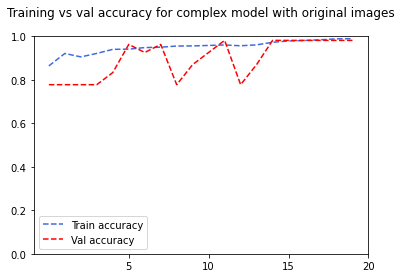

In [10]:
plt.plot(history_cmpl_orig.index, history_cmpl_orig['accuracy'], color = 'royalblue', linestyle = '--', label = 'Train accuracy')
plt.plot(history_cmpl_orig.index, history_cmpl_orig['val_accuracy'], color = 'red', linestyle = '--', label = 'Val accuracy')
plt.ylim([0, 1.0])
plt.xticks([5, 10, 15, 20])
plt.legend(loc = 'best')
plt.title('Training vs val accuracy for complex model with original images', pad = 20)
;

#### IV.2. Classification report

In [11]:
cmpl_orig_model_class_rep

,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.941909,0.982759,0.971559,0.962334,0.971698
recall,0.953782,0.978159,0.971559,0.965970,0.971559
f1-score,0.947808,0.980453,0.971559,0.964131,0.971614
support,238.000000,641.000000,0.971559,879.000000,879.000000


#### IV.3. Confusion matrix

In [12]:
cmpl_orig_model_conf_mat

Predicted,NORMAL,PNEUMONIA
Real,,
NORMAL,227,11
PNEUMONIA,14,627


## V. Segmenting images using UNET model

In [13]:
segmentation_model = load_model(seg_model, 
                                custom_objects={'dice_coef_loss': dice_coef_loss,
                                                'dice_coef': dice_coef})

segmentation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [14]:
if (input('Do you want to segment images with UNET model (Y/N, default N)?\n') or 'N') == 'Y':
    print('Segmenting images and saving to', seg_path, '...')
    for dirname, _, filenames in os.walk(orig_path):
        for filename in tqdm(filenames):
            if ('.' + orig_file_ext) in filename:
                segment_image(segmentation_model, os.path.join(dirname, filename), dirname.replace(orig_path, seg_path))

Do you want to segment images with UNET model (Y/N, default N)?



## VI. Building and training complex CNN with segmented images

In [15]:
cmpl_seg_checkp_name = input('Input path for complex model with segmented images checkpoint (XXXX.h5) (default github checkpoint path).\n') or r'.\Models\model_complex_seg_224_rgb.h5'
cmpl_seg_hist_name = input('Input path for complex model with segmented history (XXXX.csv) (default github history path).\n') or r'.\Models\history_complex_seg_224_rgb.csv'

train = False

if 'smpl_checkp_name' in locals():
    if os.path.exists(cmpl_seg_checkp_name):
        train = True if (input('Complex model with segmented checkpoint found. Do you want to retrain model (Y/N, default N)?') or 'N') == 'Y' else False
    else:
        train = True
else:
    train = True    

X = df['Filepath_seg']
Y = df['Label_name']

md_cmpl_seg_eval, history_cmpl_seg, cmpl_seg_model_class_rep, cmpl_seg_model_conf_mat, cmpl_seg_model = build_train_model(X, Y, model_cmpl, 2, 32, 30, cmpl_seg_checkp_name, cmpl_seg_hist_name, train)

Input path for complex model with segmented images checkpoint (XXXX.h5) (default github checkpoint path).

Input path for complex model with segmented history (XXXX.csv) (default github history path).

Complex model with segmented checkpoint found. Do you want to retrain model (Y/N, default N)?

Splitting data

Building Data Generators
Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.

Evaluating model
28/28 [==============================] - 13s 471ms/step - loss: 0.1569 - accuracy: 0.9727
Loss:  0.15694710612297058
Accuracy:  97.26962447166443 %


#### VI.1. Training history

''

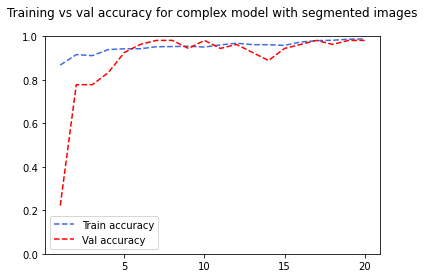

In [16]:
plt.plot(history_cmpl_seg.index + 1, history_cmpl_seg['accuracy'], color = 'royalblue', linestyle = '--', label = 'Train accuracy')
plt.plot(history_cmpl_seg.index + 1, history_cmpl_seg['val_accuracy'], color = 'red', linestyle = '--', label = 'Val accuracy')
plt.ylim([0, 1.0])
plt.xticks([5, 10, 15, 20])
plt.legend(loc = 'best')
plt.title('Training vs val accuracy for complex model with segmented images', pad = 20)
;

#### VI.2. Classification report

In [17]:
cmpl_seg_model_class_rep

,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.934959,0.987362,0.972696,0.961161,0.973173
recall,0.966387,0.975039,0.972696,0.970713,0.972696
f1-score,0.950413,0.981162,0.972696,0.965787,0.972836
support,238.000000,641.000000,0.972696,879.000000,879.000000


#### VI.3. Confusion matrix

In [18]:
cmpl_seg_model_conf_mat

Predicted,NORMAL,PNEUMONIA
Real,,
NORMAL,230,8
PNEUMONIA,16,625
